In [705]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import data_utils
importlib.reload(data_utils)
import data_pipeline
importlib.reload(data_pipeline)
from data_pipeline import DataPipeline
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)
import sklearn.datasets as datasets

Ради интереса я решил написать свою мини-библиотеку, с помощью которой можно конфигурировать обработку данных и делать красивые визуализации

### Генерация данных

In [706]:
data = [
    DataPipeline('line').generate(['X', 'Y'], datasets.make_classification, n_samples=150,
        n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, class_sep=2).process(),
    DataPipeline('moons').generate(['X', 'Y'], datasets.make_moons, n_samples=150, noise=0.15).process(),
    DataPipeline('circles').generate(['X', 'Y'], datasets.make_circles, n_samples=150, noise=0.15, factor=0.5).process()
]

### Визуализация данных

In [707]:
def draw_data(stats=[]):
    def do_draw_data(ax, p):
        X = p.val('X')
        y = p.val('Y').astype(np.bool8)
        X_b = X[y]
        X_r = X[np.invert(y)]

        ax.set_title(p.name)
        ax.scatter(X_b[:, 0], X_b[:, 1], marker='o', c='#0000FF', s=150, alpha=0.7, label='blue')
        ax.scatter(X_r[:, 0], X_r[:, 1], marker='o', c='#FF0000', s=150, alpha=0.7, label='red')
        if len(stats):
            draw_utils.draw_stats(ax, p, stats)
        
        if p.has('grid_pred'):
            Z = p.val('grid_pred') - 0.5

            cm = plt.cm.RdBu
            Z = Z.reshape(p.val('xx').shape) 
            plt.contourf(p.val('xx'), p.val('yy'), Z, cmap=cm, alpha=.5)
        
        ax.grid(True)

    return do_draw_data

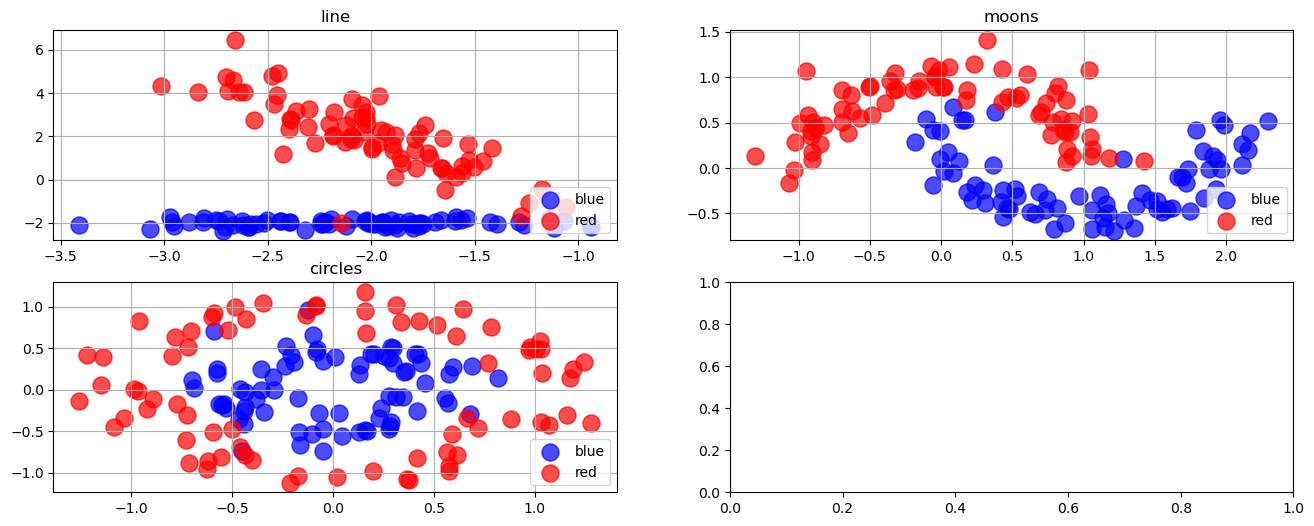

In [708]:
draw_utils.draw_plots(data, draw_data())

### Подготовка данных

In [709]:
prepare = DataPipeline('prepare_data')
prepare.transform('X', ['X', 'X_min', 'X_max'], data_utils.minmax_features, p_enable='_minmax')
prepare.transform('Y', ['Y', 'Y_min', 'Y_max'], data_utils.minmax_features, p_enable='_minmax')
prepare.transform('X', ['X', 'X_mean', 'X_std'], data_utils.std_scale_features, p_enable='_std')
prepare.transform('Y', ['Y', 'Y_mean', 'Y_std'], data_utils.std_scale_features, p_enable='_std')
prepare.transform('X', 'X_prep', data_utils.prepare_features, poly="_poly")
prepare.transform('Y', 'Y_prep', data_utils.prepare_target)

def generate_grid(X):
    h =  (X[:, 0].max() - X[:, 0].min()) / 50
    x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return np.c_[xx.ravel(), yy.ravel()], xx, yy

prepare.transform('X', ['grid', 'xx', 'yy'], generate_grid)
prepare.transform('grid', 'grid', data_utils.prepare_features, poly="_poly")
prepare.transform('X_prep', 'W', linreg_utils.generate_weights)

### Метрики

In [710]:
metrics = DataPipeline('metrics')
metrics.transform(['Y_pred', 'Y_prep'], 'BCE', linreg_utils.BCE, store_history=True)

### Линейная регрессия

In [711]:
regression_step = DataPipeline('gradient_step')
regression_step.transform(['X_prep', 'Y_prep', 'W'], 'grad_loss', linreg_utils.grad_loss)
regression_step.transform(['W', 'grad_loss'], 'W', linreg_utils.update_weights, lr="_lr")
regression_step.transform(['X_prep', 'W'], 'Y_pred', linreg_utils.predict)
regression_step.transform('Y_pred', 'Y_pred', linreg_utils.sigmoid)
regression_step.transform(['grid', 'W'], 'grid_pred', linreg_utils.predict)
regression_step.transform('grid_pred', 'grid_pred', linreg_utils.sigmoid)
regression_step.subpipeline(metrics)
linear_regression = DataPipeline.compose('linear_regression', [prepare, (regression_step, {'p_repeat':"_iterations"})])

### Пробуем линейную регрессию

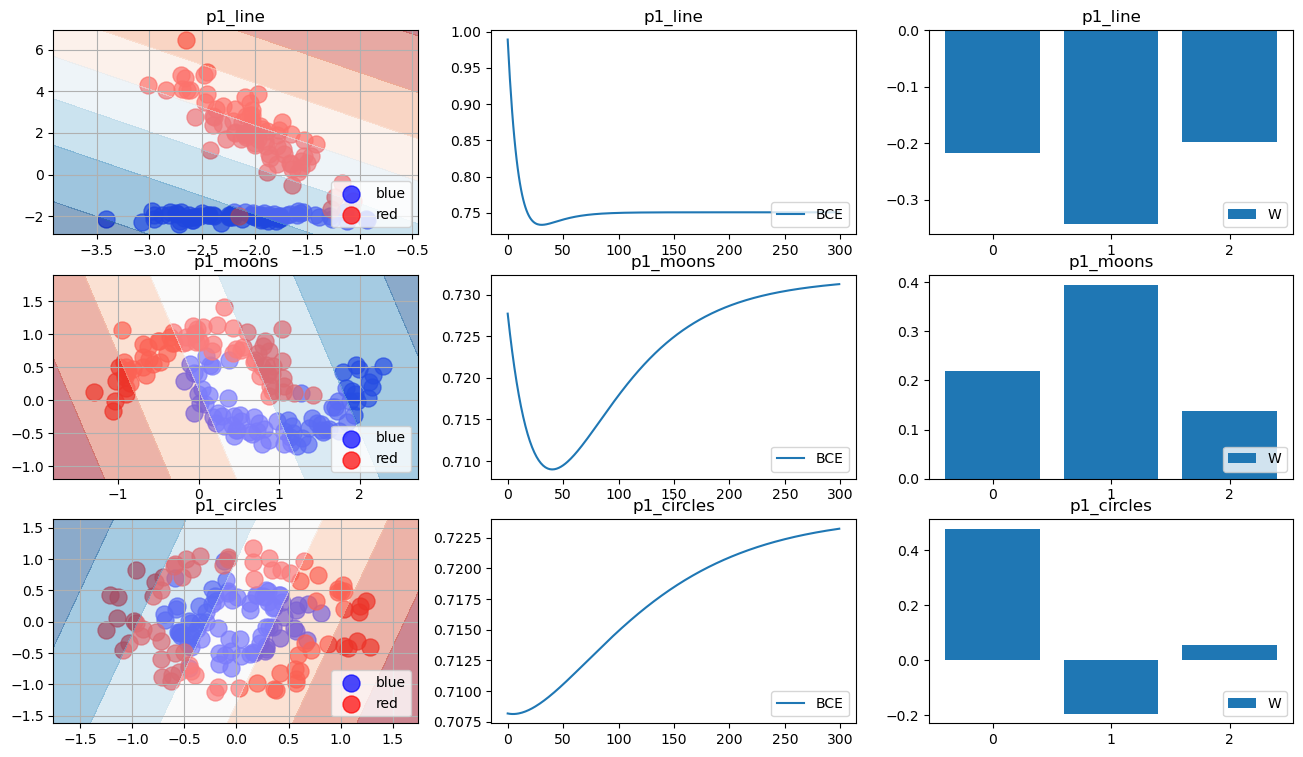

In [712]:
pipes = linear_regression.apply(DataPipeline.copy_list(data, "p1" , True), _lr=0.01, _iterations=300, _poly=1)
draw_utils.draw_plots(pipes, [draw_data(), draw_utils.draw_metric(["BCE"]), draw_utils.draw_compare_stats('W')], max_cols=3)

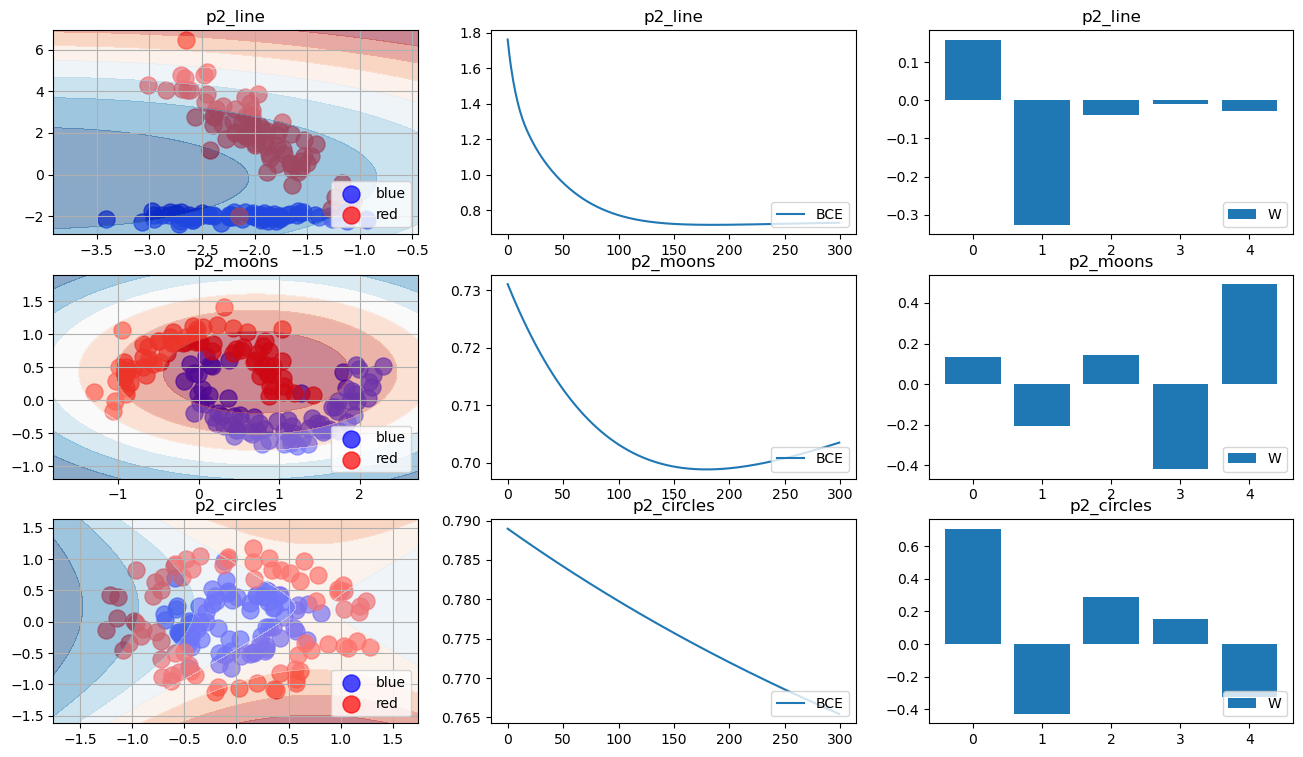

In [713]:
pipes = linear_regression.apply(DataPipeline.copy_list(data, "p2" , True), _lr=0.001, _iterations=300, _poly=2)
draw_utils.draw_plots(pipes, [draw_data(), draw_utils.draw_metric(["BCE"]), draw_utils.draw_compare_stats('W')], max_cols=3)